# Simple Neural Network Regression with Keras and JAX

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

## Introduction


In this lecture we show how to implement one-dimensional nonlinear regression
using a multilayer perceptron (i.e., neural network).

We will use the popular deep learning library [Keras](https://keras.io/), which
provides a simple interface to deep learning.

The emphasis in Keras is on providing an intuitive API, while the heavy lifting is
done by one of several possible backends.

Currently the backend library options are Tensorflow, PyTorch, and JAX.

In this lecture we will set the backend to JAX.

Our main aim is to provide a very simple introduction to deep
learning in a regression setting.

Later, in [a separate lecture](https://jax.quantecon.org/jax_nn.html), we will investigate how to do the same learning task using pure JAX, rather than relying on Keras.

If you run this lecture on [Google Colab](https://colab.research.google.com/), set the runtime environment to include a GPU.

To run this lecture on your own machine, you need to install [Google JAX](https://github.com/google/jax).

* Obviously, if you install the CPU-only version of JAX, you will not get the benefit of a hardware accelerator and this will affect your timings.

If necessary, please install Keras by uncommenting the next line.

In [1]:
!pip install --upgrade keras

Now we specify that the desired backend is JAX.

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'jax'

Now we should be able to import some tools from Keras.

(Without setting the backend to JAX, the imports below might fail – unless you have PyTorch or Tensorflow set up.  If you have problems running the next cell in Jupyter, try quitting, running `export KERAS_BACKEND="jax"` and then starting Jupyter on the command line from the same terminal.)

In [3]:
import keras

In [4]:
from keras import Sequential
from keras.layers import Dense

We'll also use the following imports.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Data

First let’s write a function to generate some data.

The data has the form

$$
y_i = f(x_i) + \epsilon_i,
    \qquad i=1, \ldots, n,
$$

where

- the input sequence $ (x_i) $ is an evenly-spaced grid,  
- $ f $ is a nonlinear transformation, and  
- each $ \epsilon_i $ is independent white noise.  


Here’s the function that creates vectors `x` and `y` according to the rule
above.

In [6]:
def generate_data(x_min=0,           # Minimum x value
                  x_max=5,           # Max x value
                  data_size=400,     # Default size for dataset
                  seed=1234):
    np.random.seed(seed)
    x = np.linspace(x_min, x_max, num=data_size)
    # y = f(x) + ϵ with f as below
    ϵ = 0.2 * np.random.randn(data_size)
    y = x**0.5 + np.sin(x) + ϵ
    # Transform to column vectors (Keras expects two dimensions, not flat arrays)
    x, y = [np.reshape(z, (data_size, 1)) for z in (x, y)]
    return x, y

Now we generate some data to train the model.

In [7]:
x, y = generate_data()

Here’s a plot of the training data.

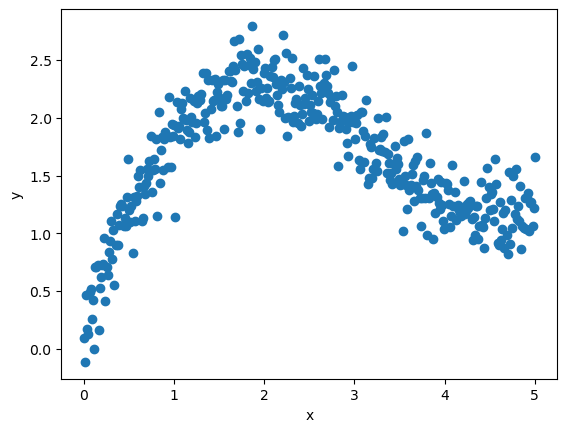

In [8]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

We’ll also use data from the same process for cross-validation.

In [9]:
x_validate, y_validate = generate_data()

## Models

We supply functions to build two types of models.

## Regression model

The first implements linear regression.

This is achieved by constructing a neural network with just one layer, that maps
to a single dimension (since the prediction is real-valued).

The object `model` will be an instance of `keras.Sequential`, which is used to
group a stack of layers into a single prediction model.

In [10]:
def build_regression_model():
    # Generate an instance of Sequential, to store layers and training attributes
    model = Sequential()
    # Add a single layer with scalar output
    model.add(Dense(units=1))  
    # Configure the model for training
    model.compile(optimizer=keras.optimizers.SGD(), 
                  loss='mean_squared_error')
    return model

In the function above you can see that

- we use stochastic gradient descent to train the model, and  
- the loss is mean squared error (MSE).  


The call `model.add` adds a single layer the activation function equal to the identity map.

MSE is the standard loss function for ordinary least squares regression.

### Deep Network

The next function creates a dense (i.e., fully connected) neural network with
3 hidden layers, where each hidden layer maps to a k-dimensional output space.

In [11]:
def build_nn_model(output_dim=10, num_layers=3, activation_function='tanh'):
    # Create a Keras Model instance using Sequential()
    model = Sequential()
    # Add layers to the network sequentially, from inputs towards outputs
    for i in range(num_layers):
        model.add(Dense(units=output_dim, activation=activation_function))
    # Add a final layer that maps to a scalar value, for regression.
    model.add(Dense(units=1))
    # Embed training configurations
    model.compile(optimizer=keras.optimizers.SGD(), 
                  loss='mean_squared_error')
    return model

### Tracking errors

The following function will be used to plot the MSE of the model during the
training process.

Initially the MSE will be relatively high, but it should fall at each iteration,
as the parameters are adjusted to better fit the data.

In [12]:
def plot_loss_history(training_history, ax):
    """
    Plot the MSE of the training data as a function of the epochs.  
    Each epoch corresponds to one pass through the data set and update of
    the parameters.

    This function acts on the training history returned by a call to the
    `fit` method of a given model.
    """
    epochs = training_history.epoch
    training_losses = training_history.history['loss']
    validation_losses = training_history.history['val_loss']
    ax.plot(epochs, 
            training_losses, 
            label='training loss')
    # Plot MSE of validation data against epoch
    ax.plot(epochs, 
            validation_losses,
            label='validation loss')
    # Add labels
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (Mean squared error)')
    ax.legend()

## Training

Now let’s go ahead and train our  models.

### Linear regression

We’ll start with linear regression.

In [13]:
regression_model = build_regression_model()

Now we train the model using the training data.

In [14]:
training_history = regression_model.fit(
    x, y, 
    batch_size=x.shape[0], 
    verbose=0,
    epochs=2000, 
    validation_data=(x_validate, y_validate)
)

Let’s have a look at the evolution of MSE as the model is trained.

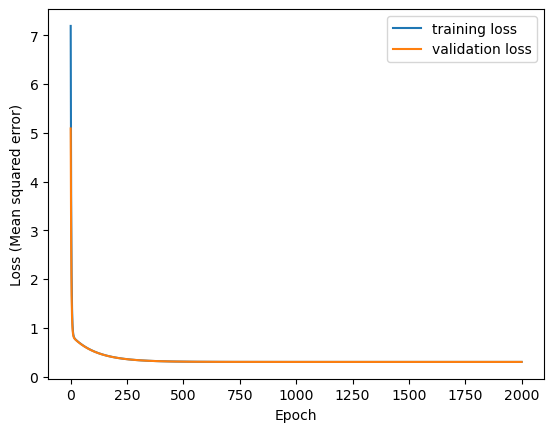

In [15]:
fig, ax = plt.subplots()
plot_loss_history(training_history, ax)
plt.show()

Let’s print the final MSE on the cross-validation data.

In [16]:
print("Testing loss on the validation set.")
regression_model.evaluate(x_validate, y_validate, verbose=2)

Testing loss on the validation set.
13/13 - 0s - 13ms/step - loss: 0.3016


0.3015977740287781

Here’s our output predictions on the cross-validation data.

In [17]:
y_predict = regression_model.predict(x_validate, verbose=2)

13/13 - 0s - 5ms/step


We use the following function to plot our predictions along with the data.

In [18]:
def plot_results(x, y, y_predict, ax):
    ax.scatter(x, y)
    ax.plot(x, y_predict, label="fitted model", color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

Let’s now call the function on the cross-validation data.

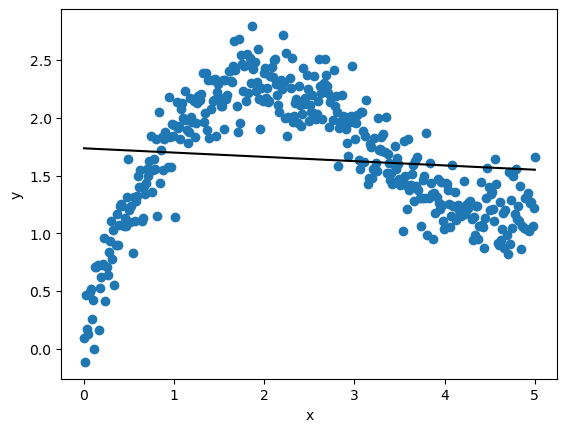

In [19]:
fig, ax = plt.subplots()
plot_results(x_validate, y_validate, y_predict, ax)
plt.show()

### Deep learning

Now let’s switch to a neural network with multiple layers.

We implement the same steps as before.

In [20]:
nn_model = build_nn_model()

In [21]:
training_history = nn_model.fit(
    x, y, 
    batch_size=x.shape[0], 
    verbose=0,
    epochs=2000, 
    validation_data=(x_validate, y_validate)
)

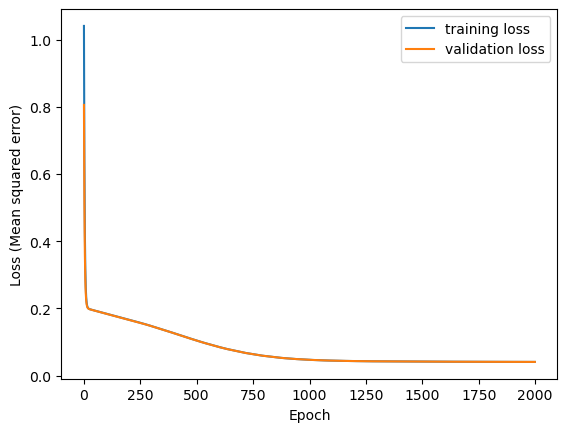

In [22]:
fig, ax = plt.subplots()
plot_loss_history(training_history, ax)
plt.show()

Here’s the final MSE for the deep learning model.

In [23]:
print("Testing loss on the validation set.")
nn_model.evaluate(x_validate, y_validate, verbose=2)

Testing loss on the validation set.


13/13 - 0s - 37ms/step - loss: 0.0406


0.040641527622938156

You will notice that this loss is much lower than the one we achieved with
linear regression, suggesting a better fit.

To confirm this, let’s look at the fitted function.

In [24]:
y_predict = nn_model.predict(x_validate, verbose=2)

13/13 - 0s - 16ms/step


In [25]:
def plot_results(x, y, y_predict, ax):
    ax.scatter(x, y)
    ax.plot(x, y_predict, label="fitted model", color='black')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

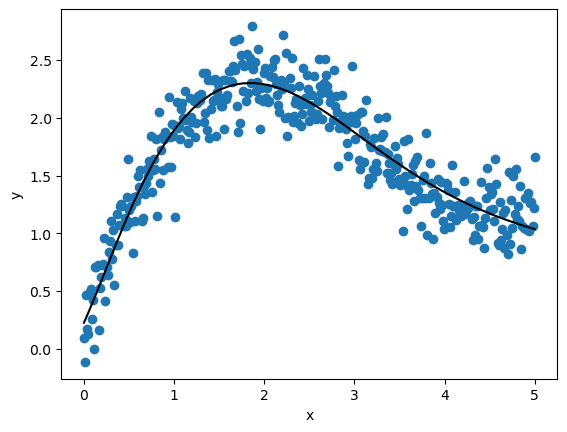

In [26]:
fig, ax = plt.subplots()
plot_results(x_validate, y_validate, y_predict, ax)
plt.show()

Not surprisingly, the multilayer neural network does a much better job of fitting the data.